In [1]:
import numpy as np
from   numpy import exp,cos,sin,pi,tan,sqrt,angle,absolute,eye,dot
import matplotlib.pyplot as plt
import seaborn # makes figures prettier (otherwise unused)
from DeDist import dedist
from __future__ import division
import dill
# removes need for plt.show() after every new plot
%matplotlib inline

In [3]:
# Set default figure size
plt.rcParams['figure.figsize'] = (10, 5)

In [21]:
# Restore session state i.e. all objects
# dill.load_session('session_state_gauss.pkl')

# Save current session state
# Unix compress file: $ gzip session_state.pkl
# dill.dump_session('session_state_gauss.pkl')

Same model setup

In [4]:
# Tuning curve parameters
AMPLITUDE = 1.0
TUNING_WIDTH = 0.5

def tuning_curve(pref_stim, stimulus):
    return AMPLITUDE * exp( - (stimulus - pref_stim)**2 / (2 * TUNING_WIDTH**2) )

def tuning_curve_2d(pref_stim, stim_1, stim_2):
    return tuning_curve(pref_stim, stim_1) + tuning_curve(pref_stim, stim_2)

def tuning_curve_theta(pref_stim, opening_angle):
    return tuning_curve_2d(pref_stim, opening_angle/2, -opening_angle/2)

Construct correlation matrix $R$ using a Gaussian correlation profile

The matrix has the form: $r_{jk} = c(\phi_j - \phi_k) + \delta_{jk}(1 - c(0))$ 
where 
$$c(\phi_j - \phi_k) = c_0 \exp\bigg(-\frac{(\phi_j - \phi_k)^2}{2L^2}\bigg)$$

In [8]:
NOISE_SIGMA = 0.2

def construct_corr_matrix(max_corr, corr_length, n_neurons=100):
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    pref_ang_dists = pref_stims - pref_stims[:,None]
    return max_corr * (exp(- (pref_ang_dists**2) / (2*corr_length**2) ) - eye(n_neurons)) + eye(n_neurons)

def construct_cov_matrix(max_corr=1.0, corr_length=0.5, n_neurons=100):
    corr_mtx = construct_corr_matrix(max_corr, corr_length, n_neurons)
    stds_mtx = NOISE_SIGMA * eye(n_neurons) 
    return dot(stds_mtx, dot(corr_mtx, stds_mtx))

Visualisation of correlation structure

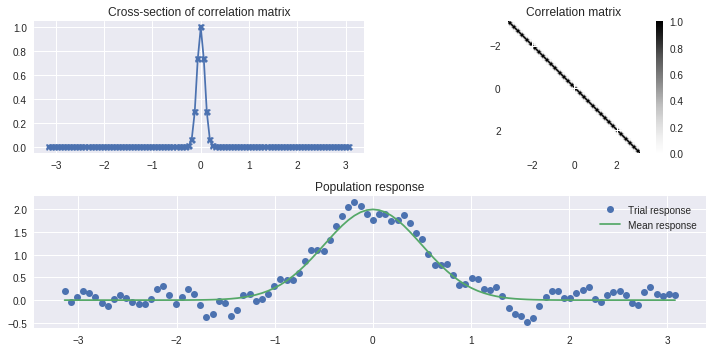

In [16]:
max_corr = 1.0
corr_length = 0.08

n_neurons = 100
pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]

# Cross-section of correlation matrix
plt.subplot(221) 
corr_mtx = construct_corr_matrix(max_corr, corr_length)
plt.plot(pref_stims, corr_mtx[50], '-X')
plt.title('Cross-section of correlation matrix')

# Correlation matrix
plt.subplot(222) 
data_coords = [pref_stims[0], pref_stims[-1], pref_stims[-1], pref_stims[0]]
plt.imshow(corr_mtx, cmap='Greys', extent=data_coords)
plt.colorbar()
plt.title('Correlation matrix')

# Population response
plt.subplot(212)
# sample population response
stim = 0.0
mean_pop_res = tuning_curve_theta(pref_stims, stim)
cov_mtx = construct_cov_matrix(max_corr, corr_length)
pop_res = np.random.multivariate_normal(mean_pop_res, cov_mtx)
plt.plot(pref_stims, pop_res, 'o', label='Trial response')
plt.plot(pref_stims, mean_pop_res, label='Mean response')
plt.legend()
plt.title('Population response')

plt.tight_layout()

In [17]:
# Candidate estimates to evaluate error function
N_CAND_ESTS = 100
CAND_ESTS = np.linspace(0, pi, N_CAND_ESTS+1)[:-1]

# Stimuli (opening angles) for which bias and variance are to be calculated
N_THETAS = 100
THETAS = np.linspace(0, pi/2, N_THETAS)

**ML code**

In [164]:
def get_ML_ests(cov_mtx, n_neurons=100, n_realisations=5000):
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    estimate_dists = np.zeros((N_THETAS, n_realisations))
    
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    
    # Simulate neuron responses followed by decoding for each stimulus in THETAS
    for stim_idx in range(N_THETAS):
        stim = THETAS[stim_idx]
                
        # Generate noisy pop. responses by sampling multivariate distribution
        avg_pop_res = tuning_curve_theta(pref_stims, stim)
        pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)
                
        # For each noisy response, compute error wrt candidate stimuli
        avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None])
        tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.pinv(cov_mtx), axes=1 )
        errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))
        
        # Find minimum error stimuli for each realisation
        estimate_dists[stim_idx,:] = CAND_ESTS[errors.argmin(axis=0)]
        
        # Compute bias and variance
        mean_est = estimate_dists[stim_idx,:].mean()
        biases[stim_idx] = mean_est - stim
        variances[stim_idx] = ((estimate_dists[stim_idx,:] - mean_est)**2).mean()

    return [estimate_dists, biases, variances]

def get_ML_ests_stim_0(cov_mtx, n_neurons=100, n_realisations=5000):
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    stim = 0.0
    estimate_dist = np.zeros(n_realisations)

    # Generate noisy pop. responses by sampling multivariate distribution
    avg_pop_res = tuning_curve_theta(pref_stims, stim)
    pop_responses = np.random.multivariate_normal(avg_pop_res, cov_mtx, n_realisations)

    # For each noisy response, compute error wrt candidate stimuli
    avg_tuning_curves = tuning_curve_theta(pref_stims, CAND_ESTS[:,None])
    tmp = np.tensordot( (pop_responses-avg_tuning_curves[:,None]), np.linalg.pinv(cov_mtx), axes=1 )
    errors = np.einsum('ijk,ijk->ij', tmp, (pop_responses-avg_tuning_curves[:,None]))

    # Find minimum error stimuli for each realisation
    estimate_dist[:] = CAND_ESTS[errors.argmin(axis=0)]

    # Compute bias and variance
    mean_est = estimate_dist.mean()
    bias = mean_est - stim
    variance = ((estimate_dist - mean_est)**2).mean()

    return (bias, variance)

Get the bias for uncorrelated model

In [93]:
cov_mtx = construct_cov_matrix(max_corr=0.0)
(bias_uncorr_theta_0, var_uncorr_theta_0) = get_ML_ests_stim_0(cov_mtx)

**Important Note**

We use the pseudo-inverse operation.

In [92]:
max_corr = 1.0

n_points = 100
corr_length_arr = np.logspace(start=-3, stop=6, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_ML_inv = np.zeros(n_points)
variances_theta_ML_inv = np.zeros(n_points)

for i in range(n_points):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_ML_inv[i], variances_theta_ML_inv[i]) = get_ML_ests_stim_0(cov_mtx)
    print i

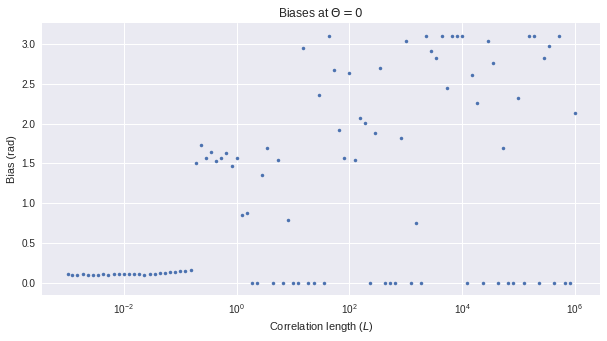

In [99]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=100)
corr_length_arr = np.round(corr_length_arr, 4)

plt.plot(corr_length_arr, biases_theta_ML_inv, '.')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

The above shows the result when we use the standard inverse operation.

**Bias vs correlation length at $\Theta=0$**

In [73]:
max_corr = 1.0

n_points = 500
corr_length_arr = np.logspace(start=-3, stop=6, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_ML = np.zeros(n_points)
variances_theta_ML = np.zeros(n_points)

for i in range(n_points):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_ML[i], variances_theta_ML[i]) = get_ML_ests_stim_0(cov_mtx)
    print i

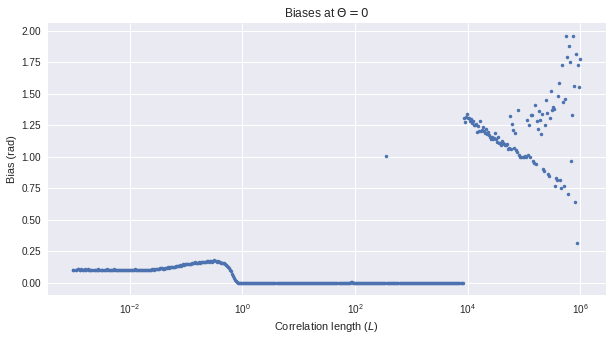

In [101]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
corr_length_arr = np.round(corr_length_arr, 4)

plt.plot(corr_length_arr, biases_theta_ML, '.')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

For $L > 10^{4}$, the bias fluctates randomly away from 0.

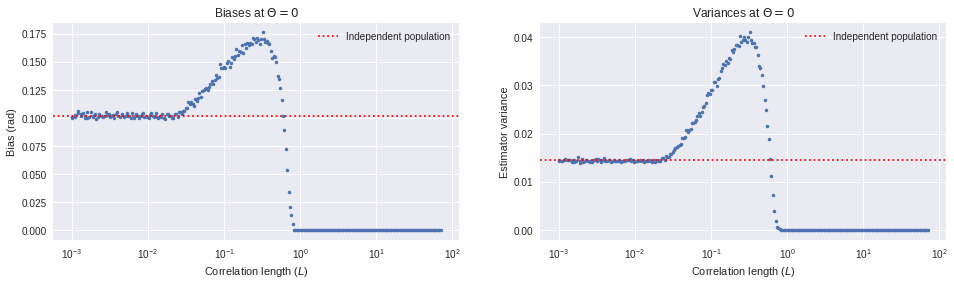

In [488]:
max_corr = 1.0
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
corr_length_arr = np.round(corr_length_arr, 4)

end_idx = 270

plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
plt.plot(corr_length_arr[:end_idx], biases_theta_ML[:end_idx], '.')
plt.axhline(y=bias_uncorr_theta_0, color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

plt.subplot(122)
plt.plot(corr_length_arr[:end_idx], variances_theta_ML[:end_idx], '.')
plt.axhline(y=var_uncorr_theta_0, color='r', linestyle=':', label='Independent population')

plt.legend()
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

Determine correlation length of maximum bias at $\Theta=0$

In [176]:
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
c = np.round(corr_length_arr, 4)

end_idx = 270

idx = np.argmax(biases_theta_ML[:end_idx])
print 'L = {0}'.format(corr_length_arr[idx])
print 'Bias = {0:.4f}'.format(biases_theta_ML[idx])

L = 0.3214
Bias = 0.1762


Bias (across THETAS) for selected correlation lengths

In [484]:
def get_corr_param_dict_lbl(max_corr=1.0, corr_length=0.5):
    return 'max_corr='+str(max_corr)+';corr_length='+str(corr_length)

In [483]:
max_corr = 1.0
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

ML_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    ML_ests[lbl] = get_ML_ests(cov_mtx)

**Bias (across THETAS) for $\Theta = 0$**

In [485]:
max_corr = 0.0

cov_mtx = construct_cov_matrix(max_corr)
lbl = get_corr_param_dict_lbl(max_corr)
ML_ests[lbl] = get_ML_ests(cov_mtx)

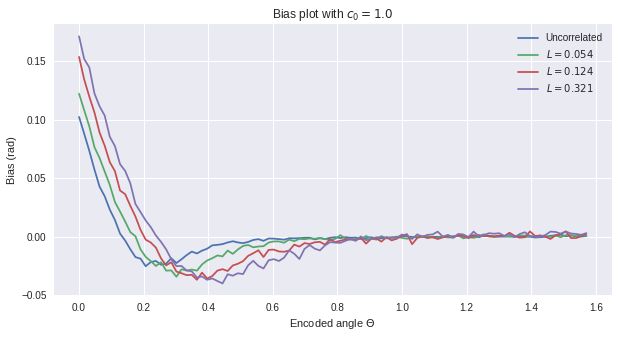

In [498]:
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

lbl = get_corr_param_dict_lbl(max_corr=0.0) # Uncorrelated case
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='Uncorrelated')

corr_length = corr_length_arr[0]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[1]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[2]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.title('Bias plot with $c_0 = 1.0$')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

Correlation lengths resulting in increased bias where $L = 0.321$ is the peak bias at $\Theta = 0$ from plot above.

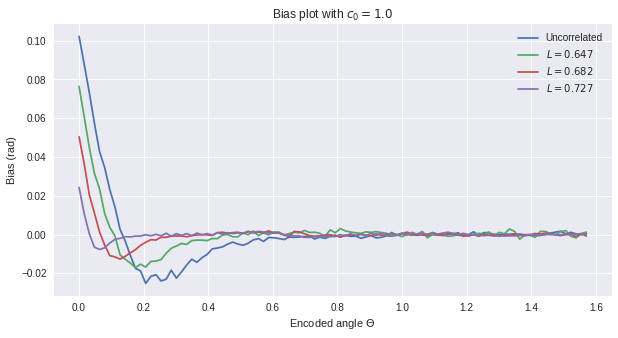

In [13]:
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

lbl = get_corr_param_dict_lbl(max_corr=0.0) # Uncorrelated case
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='Uncorrelated')

corr_length = corr_length_arr[3]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[4]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

corr_length = corr_length_arr[5]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, label='$L = {0}$'.format(corr_length))

plt.legend()
plt.title('Bias plot with $c_0 = 1.0$')
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

Correlation lengths resulting in reduced bias.

Distribution of estimates for true stimulus value 0


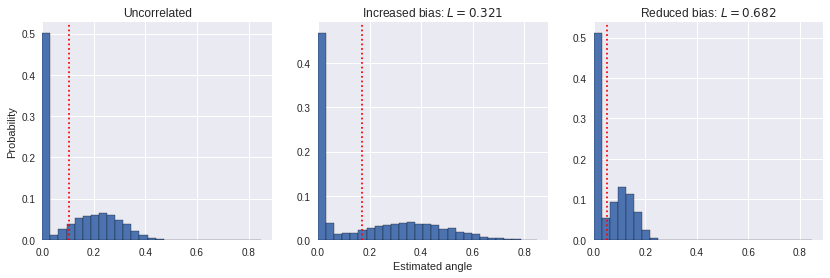

In [522]:
print('Distribution of estimates for true stimulus value 0')

plt.rcParams['figure.figsize'] = (14, 4)

end_idx = 28

plt.subplot(131)
lbl = get_corr_param_dict_lbl(max_corr=0.0)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.ylabel('Probability')
plt.title('Uncorrelated')


plt.subplot(132)
corr_length = 0.321
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('Increased bias: $L = {0}$'.format(corr_length))


plt.subplot(133)
corr_length = 0.682
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
plt.axvline(x=ML_ests[lbl][1][0], color='r', ls=':')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))


plt.rcParams['figure.figsize'] = (10, 5)


**GP code**

We have copied the function `est_p_cor()` from the DeDist package as we have had to use the pseudo-inverse operation instead.

In [38]:
from scipy.stats import mvn
from multiprocessing import Pool

def multi_fun(inputs):
    low = inputs[0]
    upp = inputs[1]
    mean = inputs[2]
    cov = inputs[3]
    p,e = mvn.mvnun(low,upp,mean,cov)
    return p

def est_p_cor(fun,theta,par,cov,x,x_,full_return=False,lowmem=False,verbose=True):
    # find dimensionality of multivar Gaussian
    ns = len(x_)

    # get inverse covariance
    # cov_i = np.linalg.inv(cov)
    cov_i = np.linalg.pinv(cov)

    # set integration bounds
    low = -np.ones(len(x_)-1)*1e50
    upp = np.zeros(len(x_)-1)

    # find real population response
    f = fun(x,theta,par)

    # make multidimensional version of x_ so less need for for loops
    # a + b.reshape(b.shape+(1,)) gives all possible combinations between
    # a and b
    x_mult = x_.reshape(x_.shape+(1,))

    # first, find all required function differences
    diffs_true = f - fun(x,x_mult,par)
    Lmeans = np.array([np.dot(np.dot(diffs_true[a, :], cov_i),
                              diffs_true[a, :]) for a in range(ns)])
    diffs = (fun(x,x_mult,par)[:,None]-fun(x,x_mult,par))

    # then, find the means
    means = np.zeros((ns-1, ns))
    if verbose: print 'finding means'
    for m in range(ns):
        if verbose: print '\r'+str(m),
        means[:m, m] = Lmeans[m] - Lmeans[:m]
        means[m:, m] = Lmeans[m] - Lmeans[m+1:]
    if verbose: print ''

    # now for the covariances
    if verbose:
        print 'finding covariances, ',
        print 'doing set x of ' + str(ns) + ':'
    # loop over coveriances to find
    covs = np.zeros((ns-1, ns-1, ns))
    for m in range(ns):
        if verbose: print '\r'+str(m),
        for a in range(m):
            for b in range(m):
                covs[a, b, m] = np.dot(np.dot(diffs[m, a, :], cov_i),
                                       diffs[m, b, :])
            for b in range(m+1, ns):
                covs[a, b-1, m] = np.dot(np.dot(diffs[m, a, :], cov_i),
                                         diffs[m, b, :])
        for a in range(m+1, ns):
            for b in range(m):
                covs[a-1, b, m] = np.dot(np.dot(diffs[m, a, :], cov_i),
                                         diffs[m, b, :])
            for b in range(m+1, ns):
                covs[a-1, b-1, m] = np.dot(np.dot(diffs[m, a, :], cov_i),
                                           diffs[m, b, :])

    if verbose: print ''

    # calculate the cumulative distribution for each of the calculated covs
    if verbose: print 'Calculating cumulative distributions'

    # calculate probabilities
    pool = Pool(None)  # to use less than max processes, change 'None' to number
    inputs = [[low, upp, means[:, i], 4*covs[:, :, i]] for i in range(ns)]
    p = pool.map(multi_fun, inputs)
    pool.close()

    if full_return:
        return p, means, covs
    else:
        return p

In [16]:
def tuning_curve_theta_dedist(pref_stim, opening_angle, par):
    return tuning_curve_theta(pref_stim, opening_angle)

def get_GP_ests(cov_mtx, n_neurons=100):
    prob_dists = np.zeros((N_THETAS, N_CAND_ESTS))
    biases = np.zeros(N_THETAS)
    variances = np.zeros(N_THETAS)
    
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]

    fun = tuning_curve_theta_dedist
    for i in range(N_THETAS):
        stim = THETAS[i]

        prob_dist = est_p_cor(fun, stim, 0, cov_mtx, pref_stims, CAND_ESTS, verbose=False)

        mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
        biases[i] = mean_est - stim
        variances[i] = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2

        prob_dists[i,:] = np.asarray(prob_dist)
        
    return [prob_dists, biases, variances]

def get_GP_ests_stim_0(cov_mtx, n_neurons=100):
    pref_stims = np.linspace(-pi, pi, n_neurons+1)[:-1]
    stim = 0.0
    
    fun = tuning_curve_theta_dedist
    prob_dist = est_p_cor(fun, stim, 0, cov_mtx, pref_stims, CAND_ESTS, verbose=False)

    mean_est = np.sum(prob_dist * CAND_ESTS) / np.sum(prob_dist)
    bias = mean_est - stim
    var = np.sum(prob_dist * CAND_ESTS * CAND_ESTS) / np.sum(prob_dist) - mean_est**2
    
    return (bias, var)

Get bias for uncorrelated model (GP)

In [47]:
cov_mtx = construct_cov_matrix(max_corr=0.0)
(bias_uncorr_theta_0_GP, var_uncorr_theta_0_GP) = get_GP_ests_stim_0(cov_mtx)

**Bias vs correlation length at $\Theta=0$ using GP**

In [37]:
max_corr = 1.0

n_points = 200
corr_length_arr = np.logspace(start=-3, stop=2, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

biases_theta_GP = np.zeros(n_points)
variances_theta_GP = np.zeros(n_points)

for i in range(n_points):
    cov_mtx = construct_cov_matrix(max_corr, corr_length_arr[i])
    (biases_theta_GP[i], variances_theta_GP[i]) = get_GP_ests_stim_0(cov_mtx)
    print i

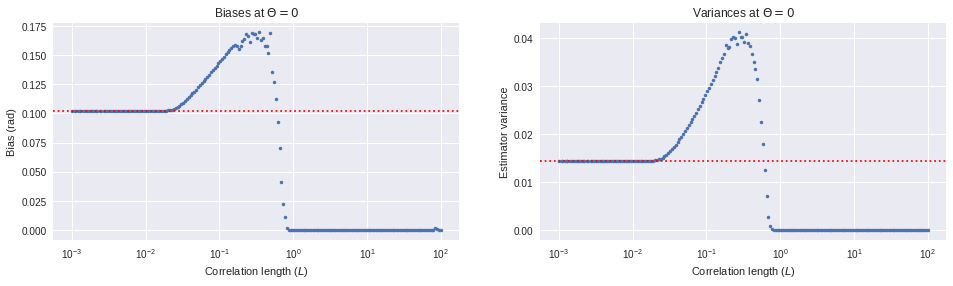

In [50]:
max_corr = 1.0
n_points = 200
corr_length_arr = np.logspace(start=-3, stop=2, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

plt.rcParams['figure.figsize'] = (16, 4)

plt.subplot(121)
plt.plot(corr_length_arr, biases_theta_GP, '.')
plt.axhline(y=bias_uncorr_theta_0_GP, color='r', linestyle=':', label='Independent population')
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')

plt.subplot(122)
plt.plot(corr_length_arr, variances_theta_GP, '.')
plt.axhline(y=var_uncorr_theta_0_GP, color='r', linestyle=':', label='Independent population')
plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Estimator variance')
plt.title('Variances at $\Theta = 0$')

plt.rcParams['figure.figsize'] = (10, 5)

We notice that the results are not smooth - this is a result of using pseudo-inverse.

Any way of correcting this?

Check that ML and GP results match up

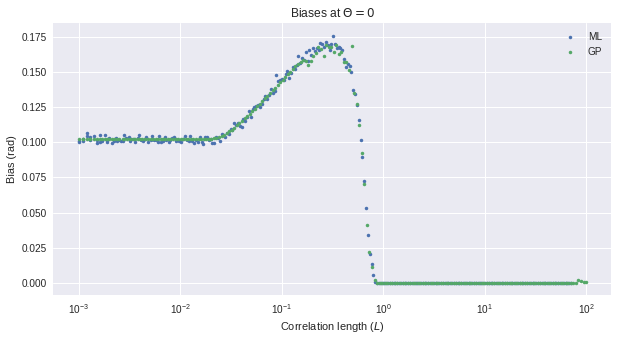

In [46]:
corr_length_arr = np.logspace(start=-3, stop=6, num=500)
corr_length_arr = np.round(corr_length_arr, 4)
end_idx = 270
plt.plot(corr_length_arr[:end_idx], biases_theta_ML[:end_idx], '.', label='ML')

corr_length_arr = np.logspace(start=-3, stop=2, num=200)
corr_length_arr = np.round(corr_length_arr, 4)
plt.plot(corr_length_arr, biases_theta_GP, '.', label='GP')

plt.xscale('log')
plt.xlabel('Correlation length ($L$)')
plt.ylabel('Bias (rad)')
plt.title('Biases at $\Theta = 0$')
plt.legend()

Determine correlation length that gives rise to peak bias

In [42]:
n_points = 200
corr_length_arr = np.logspace(start=-3, stop=2, num=n_points)
corr_length_arr = np.round(corr_length_arr, 4)

idx = np.argmax(biases_theta_GP)
print 'L = {0}'.format(corr_length_arr[idx])
print 'Bias = {0:.4f}'.format(biases_theta_GP[idx])

L = 0.3449
Bias = 0.1694


**Bias (across THETAS) for $\Theta = 0$**

In [52]:
max_corr = 1.0
corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

GP_ests = dict()
for corr_length in corr_length_arr:
    cov_mtx = construct_cov_matrix(max_corr, corr_length)
    lbl = get_corr_param_dict_lbl(max_corr, corr_length)
    GP_ests[lbl] = get_GP_ests(cov_mtx)

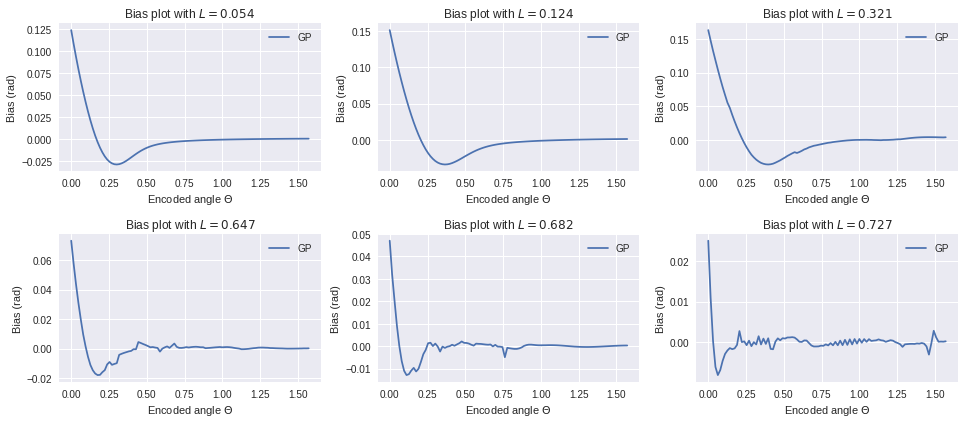

In [76]:
plt.rcParams['figure.figsize'] = (13.5, 6)

corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

show_ML = False

plt.subplot(231)
corr_length = corr_length_arr[0]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')


plt.subplot(232)
corr_length = corr_length_arr[1]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')


plt.subplot(233)
corr_length = corr_length_arr[2]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')


plt.subplot(234)
corr_length = corr_length_arr[3]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')


plt.subplot(235)
corr_length = corr_length_arr[4]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')


plt.subplot(236)
corr_length = corr_length_arr[5]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
if show_ML:
    plt.plot(THETAS, biases, '.', label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

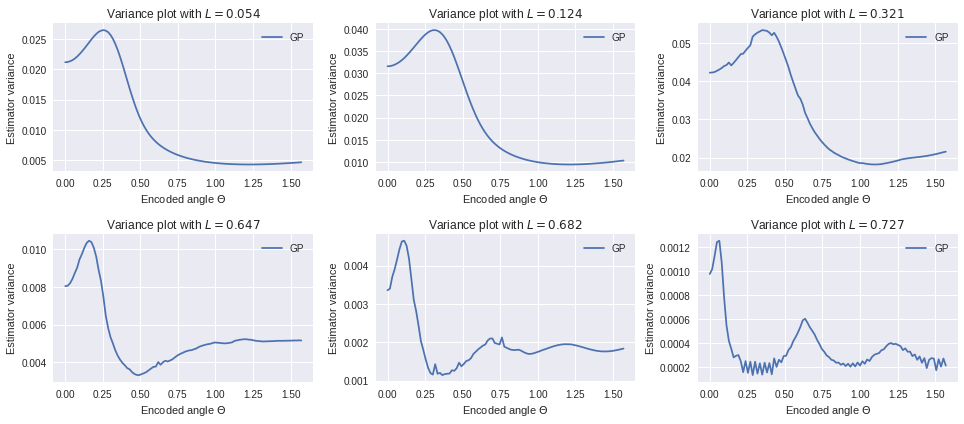

In [74]:
plt.rcParams['figure.figsize'] = (13.5, 6)

corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])

show_ML = False

plt.subplot(231)
corr_length = corr_length_arr[0]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')


plt.subplot(232)
corr_length = corr_length_arr[1]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')


plt.subplot(233)
corr_length = corr_length_arr[2]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')


plt.subplot(234)
corr_length = corr_length_arr[3]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')


plt.subplot(235)
corr_length = corr_length_arr[4]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')


plt.subplot(236)
corr_length = corr_length_arr[5]
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
if show_ML:
    plt.plot(THETAS, variances, '.', label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

Firstly, the ML estimates match the GP curve closely.

Secondly, we observe that as we increase the correlation length, the bias/variance curve becomes distorted.

The oscillating behaviour visible in the $L=0.727$ plot is similar to behaviour observed during the exponential decay correlation structure investigation. We observed this for high correlation lengths (e.g. $> 10^2$). However, due to the form of the Gaussian function, we get stronger correlations at smaller correlation lengths. 

Thus, it is worth increasing *N_CAND_EST* and see if the behaviour still holds.

**Distribution of estimates at $\Theta = 0$ for different Ls**

Distribution of estimates for true stimulus value 0


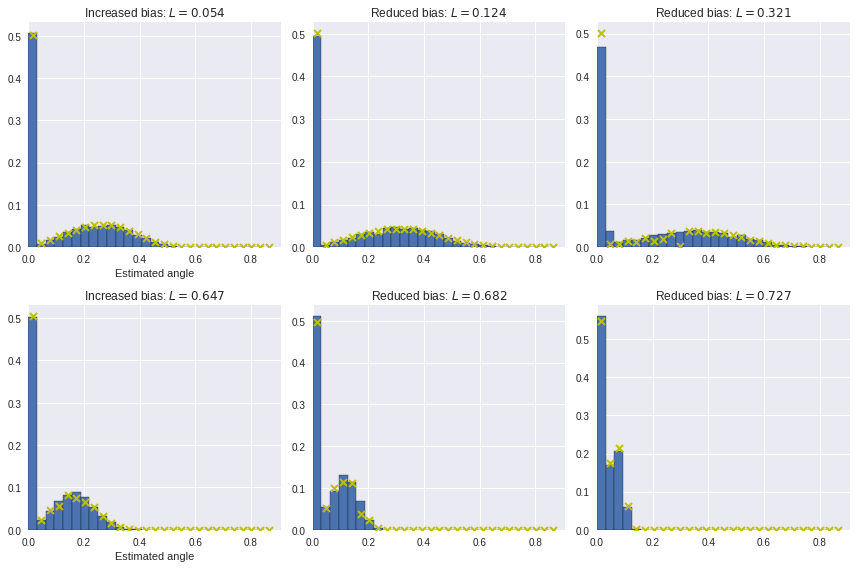

In [19]:
print('Distribution of estimates for true stimulus value 0')

plt.rcParams['figure.figsize'] = (12, 8)

end_idx = 28

corr_length_arr = np.asarray([0.054, 0.124, 0.321, 0.647, 0.682, 0.727])
diff_cand_est = (CAND_ESTS[1] - CAND_ESTS[0]) / 2

plt.subplot(231)
corr_length = corr_length_arr[0]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('Increased bias: $L = {0}$'.format(corr_length))


plt.subplot(232)
corr_length = corr_length_arr[1]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))


plt.subplot(233)
corr_length = corr_length_arr[2]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))

plt.subplot(234)
corr_length = corr_length_arr[3]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.xlabel('Estimated angle')
plt.title('Increased bias: $L = {0}$'.format(corr_length))


plt.subplot(235)
corr_length = corr_length_arr[4]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))


plt.subplot(236)
corr_length = corr_length_arr[5]
lbl = get_corr_param_dict_lbl(max_corr=max_corr, corr_length=corr_length)
est_dist = ML_ests[lbl][0][0,:]
weights = np.ones_like(est_dist)/float(len(est_dist))
plt.hist(est_dist, weights=weights, bins=CAND_ESTS[:end_idx], edgecolor='black')
prob_dist = GP_ests[lbl][0][0,:end_idx]
plt.plot(CAND_ESTS[:end_idx] + diff_cand_est, prob_dist, 'x', mew=2, color='y')
plt.xlim(0)
plt.title('Reduced bias: $L = {0}$'.format(corr_length))

plt.tight_layout()
plt.rcParams['figure.figsize'] = (10, 5)

We observe that the 2nd component of the estimate distribution for the two correlated models do not show a smooth bell-shaped curve for the GP approach (yellow crosses).

$L = 0.727$ (high corr length) with ML and GP

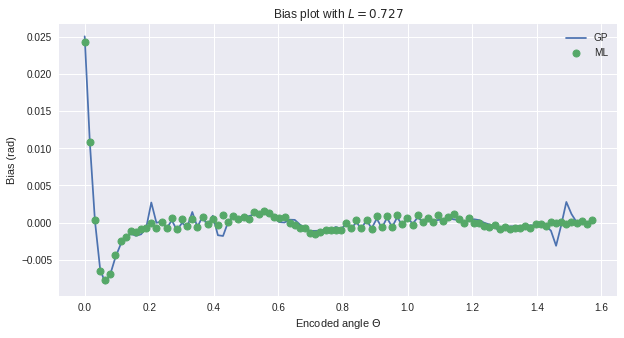

In [15]:
corr_length = corr_length_arr[5] # L = 0.727
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
biases = GP_ests[lbl][1]
plt.plot(THETAS, biases, label='GP')
biases = ML_ests[lbl][1]
plt.plot(THETAS, biases, 'o', mew=1, label='ML')

plt.legend()
plt.title('Bias plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Bias (rad)')

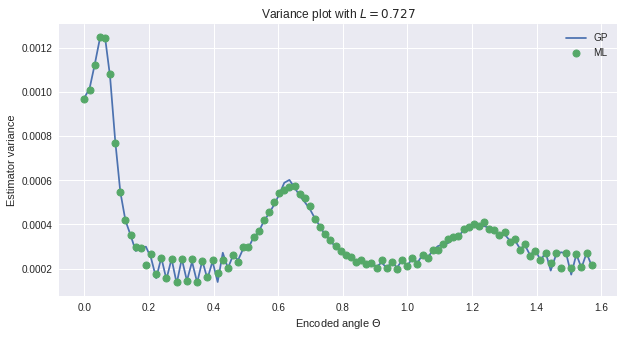

In [14]:
corr_length = corr_length_arr[5] # L = 0.727
lbl = get_corr_param_dict_lbl(corr_length=corr_length)
variances = GP_ests[lbl][2]
plt.plot(THETAS, variances, label='GP')
variances = ML_ests[lbl][2]
plt.plot(THETAS, variances, 'o', mew=1, label='ML')

plt.legend()
plt.title('Variance plot with $L={0}$'.format(corr_length))
plt.xlabel('Encoded angle $\Theta$')
plt.ylabel('Estimator variance')

The above plots verify that the distortion of the bias/variance occurs for both ML and GP.